In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM
%store -r Y_motion_CoM
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(12870, 28)
(12870, 2)


In [6]:
X_motion_CoM[0].shape

(28,)

In [27]:
# Shuffle dataset
shuffled_idx = np.random.permutation(len(X_motion_CoM))
X = X_motion_CoM[shuffled_idx].astype("float32")
Y = Y_motion_CoM[shuffled_idx].astype("float32")

# Features
X = np.hstack((X[:, :2], np.array([X[:, 5]]).T, # Motion command
               X[:, 6:8], X[:, 9:11], X[:, 12:14], X[:, 15:17], # Relative feet position
               X[:, 24:26], # Swinging configuration
               X[:, 26:28])) # Previous displacement

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=40)

# Create the model
model = Sequential()
model.add(Input(shape=(15,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='linear'))

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50),
]

# Configure the model and start training
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(
    X_train,
    Y_train,
    batch_size=100,
    epochs=500,
    verbose=2,
    callbacks=callbacks,
    validation_split=0.2
)

Epoch 1/500
83/83 - 0s - loss: 0.0277 - accuracy: 0.7620 - val_loss: 0.0100 - val_accuracy: 0.8699
Epoch 2/500
83/83 - 0s - loss: 0.0088 - accuracy: 0.9229 - val_loss: 0.0087 - val_accuracy: 0.9553
Epoch 3/500
83/83 - 0s - loss: 0.0084 - accuracy: 0.9407 - val_loss: 0.0082 - val_accuracy: 0.9568
Epoch 4/500
83/83 - 0s - loss: 0.0080 - accuracy: 0.9429 - val_loss: 0.0082 - val_accuracy: 0.9549
Epoch 5/500
83/83 - 0s - loss: 0.0080 - accuracy: 0.9443 - val_loss: 0.0080 - val_accuracy: 0.9563
Epoch 6/500
83/83 - 0s - loss: 0.0079 - accuracy: 0.9359 - val_loss: 0.0085 - val_accuracy: 0.9204
Epoch 7/500
83/83 - 0s - loss: 0.0079 - accuracy: 0.9438 - val_loss: 0.0082 - val_accuracy: 0.9568
Epoch 8/500
83/83 - 0s - loss: 0.0077 - accuracy: 0.9435 - val_loss: 0.0078 - val_accuracy: 0.9544
Epoch 9/500
83/83 - 0s - loss: 0.0078 - accuracy: 0.9404 - val_loss: 0.0080 - val_accuracy: 0.9189
Epoch 10/500
83/83 - 0s - loss: 0.0077 - accuracy: 0.9428 - val_loss: 0.0081 - val_accuracy: 0.9573
Epoch 11/

In [28]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

81/81 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 0.9549
Test loss:  0.007121845614165068
Test accuracy:  0.9549339413642883


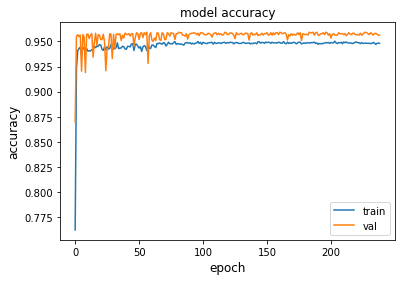

In [29]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

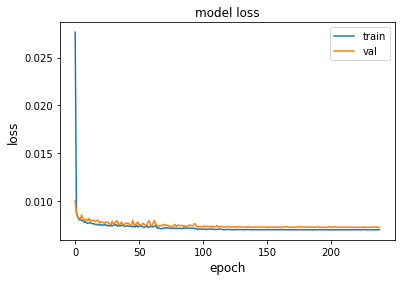

In [30]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [31]:
# Generate predictions
predictions = model.predict(X_test)
print("Predictions shape: ", predictions.shape)

Predictions shape:  (2574, 2)


In [32]:
test_error =  np.abs(Y_test - predictions)
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

In [33]:
print(f'Mean error: {mean_error}. Min error: {min_error}, Max error: {max_error}. Std error: {std_error}.')

Mean error: 0.007121846545487642. Min error: 2.364860847592354e-06, Max error: 0.09203723073005676. Std error: 0.009609234519302845.
